In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Build and train a network.

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Dense(64, input_shape=(28*28,), activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

x_train shape: (60000, 784)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 1s 24us/step - loss: 0.4560 - acc: 0.8608 - val_loss: 0.2486 - val_acc: 0.9272
Epoch 2/3
60000/60000 [==============================] - 1s 22us/step - loss: 0.2255 - acc: 0.9326 - val_loss: 0.1908 - val_acc: 0.9423
Epoch 3/3
60000/60000 [==============================] - 1s 22us/step - loss: 0.1730 - acc: 0.9484 - val_loss: 0.1517 - val_acc: 0.9536


In [6]:
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test[0:1]
    ys = y_test[0:1]
    
    #attributions = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    attributions = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('shapley', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('occlusion', target_tensor * ys, input_tensor, xs)

{'Relu': 'DeepExplainGrad', 'Elu': 'DeepExplainGrad', 'Sigmoid': 'DeepExplainGrad', 'Tanh': 'DeepExplainGrad', 'Softplus': 'DeepExplainGrad', 'MatMul': 'MatMulDeepExplainGrad'}
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepLIFT: computing references...
[<tf.Operation 'dense_1/Relu' type=Relu>, <tf.Operation 'model_1/dense_1/Relu' type=Relu>, <tf.Operation 'model_2/dense_1/Relu' type=Relu>]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

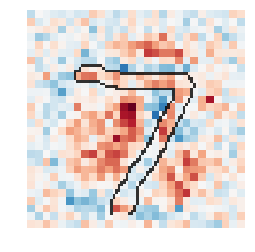

In [7]:
# Plot attributions
from utils import plot, plt
%matplotlib inline
plot(attributions.reshape(28,28), xs.reshape(28, 28))